<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/last/02_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn imbalanced-learn "ray[tune]"
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [2]:
# @title DT
class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch(BaseEstimator, ClassifierMixin):
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

  def predict_proba(self, X):
    X = np.array(X)
    probs = []
    for sample in X:
        node = self.root
        while not isinstance(node, LeafNode):
            feature_value = sample[node.feature_index]
            if feature_value >= node.threshold:
                node = node.left
            else:
                node = node.right
        # compute class probability in this leaf node
        y_leaf = node.prediction_value
        # If you only stored a single class, just make it binary
        if y_leaf == 1:
            probs.append(1.0)
        else:
            probs.append(0.0)
    return np.array(probs)

In [3]:
import kagglehub
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"
df = pd.read_csv(file_path)
df.head()

100%|██████████| 4.47M/4.47M [00:00<00:00, 93.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [4]:
df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


/tmp/ipython-input-2508231616.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


In [5]:
df

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [6]:
df_unique

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
18,C_1,alive,2017,942.700,1413.200,40.500,126.500,547.900,15.600,203.000,...,1748.300,1524.700,177.200,86.000,335.100,333.300,701.200,1748.300,588.400,1621.800
128,C_10,alive,2017,1016.288,2096.751,534.118,1468.545,289.270,488.456,415.068,...,3565.296,17019.082,4789.713,934.427,1468.545,1197.852,2397.509,3565.296,11883.352,2096.751
1202,C_100,alive,2003,20.422,9.668,4.282,12.949,0.143,12.429,2.633,...,26.603,92.116,0.000,8.667,16.935,4.837,76.871,26.603,5.845,13.654
11944,C_1000,alive,2017,4324.000,1713.000,180.000,2939.000,0.000,1496.000,1319.000,...,6063.000,9425.000,3170.000,2759.000,4350.000,3214.000,9376.000,6063.000,7307.000,3124.000
11957,C_1001,alive,2010,22357.000,105938.000,271.000,2369.000,9225.000,1202.000,9187.000,...,112084.000,30886.000,3587.000,2098.000,6146.000,18726.000,8347.000,112084.000,23666.000,109715.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11857,C_995,alive,2000,1076.559,2955.617,146.214,613.684,408.550,200.967,538.403,...,4247.504,2668.924,451.336,467.470,1291.887,971.687,1159.964,4247.504,2082.185,3633.820
11864,C_996,alive,2000,82.052,115.784,3.425,7.331,52.031,-0.086,28.381,...,141.118,123.685,67.476,3.906,25.334,22.464,25.933,141.118,93.478,133.787
11878,C_997,alive,2011,1222.900,2089.300,85.800,637.000,613.700,374.200,427.000,...,3697.600,4087.800,1029.700,551.200,1608.300,993.300,779.800,3697.600,2469.300,3060.600
11900,C_998,failed,2013,1080.200,2716.846,84.580,-259.085,425.986,-516.913,471.131,...,2658.932,2807.371,49.019,-343.665,-57.914,1120.984,-211.288,2658.932,1367.027,2918.017


In [7]:
X = df_unique[
    ["X8", "X17", "X3", "X11", "X15", "X1", "X6"]
]
y = df_unique["status_label"].map({"alive": 0, "failed": 1})

In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)


In [9]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 5448
Bankruptcy: 383


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [11]:

sm = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [12]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 5448
Bankruptcy: 5448


In [14]:
# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

# Define the Decision Tree model
model = DecisionTreeClassifier()

grid_dt = GridSearchCV(model, params, cv=4, scoring="f1")
grid_dt.fit(X_train, y_train)
print("Best parameters:\n", grid_dt.best_params_)
print("Best score:", grid_dt.best_score_)

Best parameters:
 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8468560517207231


In [17]:
criterion = "entropy"
max_depth= None
min_samples_leaf = 1
min_samples_split= 2


In [20]:
tree = DecisionTreeClassifierFromScratch(
    max_depth=20,
    criterion=criterion,
    # min_samples_leaf=min_samples_leaf,
    min_sample_split=min_samples_split,
)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
tree.draw_tree()

  (0) Is 3>=6.206468111102405e-05?: entropy:0.06
 ----- True branch :)
    (1) Is 6>=182.917?: entropy:0.02
   ----- True branch :)
      (2) Is 0>=22179.1982?: entropy:0.07
     ----- True branch :)
        The predicted value --> 0.0
     ----- False branch :)
        (3) Is 4>=309.9244029099086?: entropy:0.07
       ----- True branch :)
          (4) Is 2>=99.052146496005?: entropy:0.06
         ----- True branch :)
            (5) Is 5>=242.31?: entropy:0.07
           ----- True branch :)
              (6) Is 4>=4684.0?: entropy:0.06
             ----- True branch :)
                The predicted value --> 0.0
             ----- False branch :)
                (7) Is 5>=11310.059786061418?: entropy:0.06
               ----- True branch :)
                  The predicted value --> 1.0
               ----- False branch :)
                  (8) Is 4>=716.2267691209556?: entropy:0.05
                 ----- True branch :)
                    (9) Is 0>=7555.54?: entropy:0.06
           

In [21]:
from sklearn.metrics import accuracy_score, f1_score
score = accuracy_score(y_test, y_pred)
print("Accuracy:", score)
score = f1_score(y_test, y_pred)
print("F1_score:", score)

Accuracy: 0.7697452229299363
F1_score: 0.1278648974668275


In [22]:
def predict(model):
    model.fit(X_train, y_train)
    model.predict(X_test)
    print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

In [23]:
predict(tree)

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2914
           1       0.09      0.23      0.13       226

    accuracy                           0.77      3140
   macro avg       0.51      0.52      0.50      3140
weighted avg       0.87      0.77      0.81      3140



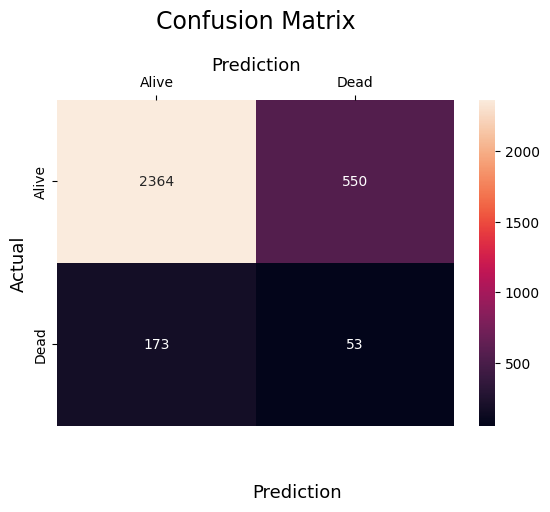

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

AUC: 0.5229


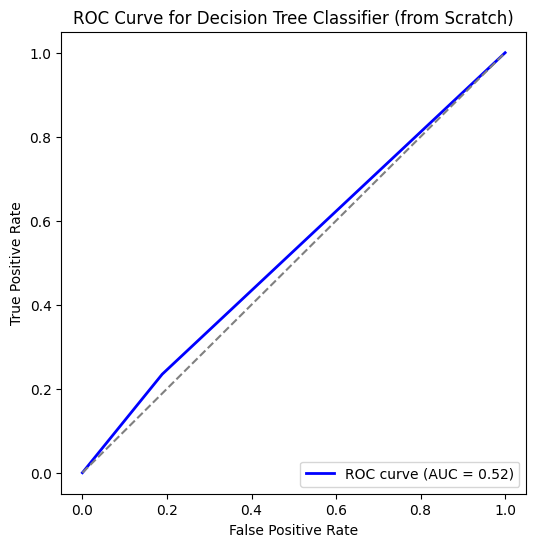

In [25]:
# ROC & AUC
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# Get probabilities (or scores)
y_pred_proba = tree.predict_proba(X_test)

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier (from Scratch)')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(
    criterion = "entropy",
max_depth= 20,
min_samples_leaf = 1,
min_samples_split= 2,
)
tree_sk.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20)

In [41]:
y_t_pred = tree_sk.predict(X_test)
accuracy_score(y_test, y_t_pred)

0.7681528662420383

In [42]:

f1_score(y_test, y_t_pred)

0.13126491646778043

In [44]:
confusion_matrix(y_test, y_t_pred)

array([[2357,  557],
       [ 171,   55]])

In [43]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree_images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree_sk, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "bankruptcy.dot"),
    feature_names = X.columns.tolist(),
    class_names = y.unique().astype(str).tolist(),
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "bankruptcy.dot"))